In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Load annotations

In [2]:
cell_line_info = pd.read_csv("../data/sample_info.csv")
cell_line_annotations = pd.read_excel("../data/41586_2019_1186_MOESM4_ESM.xlsx",
                                      sheet_name="Cell Line Annotations")

hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
tertp = pd.read_excel("../data/41586_2019_1186_MOESM8_ESM.xlsx",skiprows=4)

fusions = pd.read_csv("../data/CCLE_Fusions_20181130.txt",sep="\t")
copynumber = pd.read_hdf("../data/CCLE_gene_cn.hdf",key="copynumber")
copynumber = copynumber.dropna(how="any",thresh=1000,axis=1)

tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")

ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")
exonusage = pd.read_hdf("../data/CCLE_RNAseq_ExonUsageRatio_20180929.hdf",key="exonusage")

mirna = pd.read_hdf("../data/CCLE_miRNA_20181103.hdf",key="mirna")
chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
rppa = pd.read_hdf("../data/CCLE_RPPA_20181003.hdf",key="rppa")

msi = pd.read_excel("../data/41586_2019_1186_MOESM10_ESM.xlsx",sheet_name="MSI calls")
absolute = pd.read_excel("../data/CCLE_ABSOLUTE_combined_20181227.xlsx",
                         sheet_name = "ABSOLUTE_combined.table")

# Cell line primary sites

In [3]:
subtypes = cell_line_annotations[["depMapID","type_refined"]].set_index("depMapID")
subtypes = subtypes["type_refined"]
subtypes = subtypes.dropna()
subtypes = subtypes.apply(lambda x: x.capitalize().replace("_"," "))

rename_map = {"T-cell lymphoma other":"Other T-cell lymphoma",
              "Aml":"AML",
              "Ewings sarcoma": "Ewing's sarcoma",
              "Fibroblast like":"Fibroblast-like",
              "Lung nsc":"Lunc, NSC",
              "Lymphoma hodgkin":"Hodgkin's lymphoma",
              "Lymphoma dlbcl":"DLBCL",
              "T-cell all":"T-cell ALL",
              "B-cell all":"B-cell ALL",
              "Cml":"CML",
              "B-cell lymphoma other":"Other B-cell lymphoma",
              "Leukemia other":"Other leukemia",
              "Lymphoma burkitt":"Burkitt's lymphoma"
             }

subtypes = subtypes.apply(lambda x:rename_map.get(x,x))

# Select annotations

## Top recurrent mutations

In [4]:
def get_top_muts():
    
    align_hs_muts, align_damaging_muts = hs_muts.align(damaging_muts,join="outer",axis=1)
    align_hs_muts = align_hs_muts.fillna(0)
    align_damaging_muts = align_damaging_muts.fillna(0)
    
    hs_damaging_muts = (align_hs_muts+align_damaging_muts).clip(0,1)
        
    mut_totals = hs_damaging_muts.sum()
    mut_totals = mut_totals.sort_values()
    
    return hs_damaging_muts[mut_totals.index[-8:]]
    
muts = get_top_muts()

## TERT promoter mutations

In [5]:
tertp_mut = tertp[["depMapID","TERT_promoter_mutation"]].set_index("depMapID")!="wildtype"

## Fusions

In [6]:
def get_fusions():

    fusions["value"] = 1

    fusions_mat = pd.pivot_table(fusions, values="value",
                                index=["BroadID"], columns="X.FusionName", fill_value=0)
    
    fusions_mat.columns = fusions_mat.columns.map(lambda x: x.replace("--","-"))

    return fusions_mat[["BCR-ABL1","EWSR1-FLI1","KMT2A-MLLT3"]]

select_fusions = get_fusions()

## Top continuous annotations

In [7]:
def top_variable(annotations, top_n,clip_left=-3,clip_right=3):
    
    stdevs = annotations.std()
    stdevs = stdevs.sort_values()
    
    top_names = stdevs.index[-top_n:]
    
    top_annotations = annotations[top_names]
    top_annotations = (top_annotations - top_annotations.mean())/top_annotations.std()
    
    top_annotations = top_annotations.clip(clip_left,clip_right)
    
    return top_annotations

In [8]:
select_copynumber = top_variable(copynumber, 1000)
select_meth = top_variable(tss1kb_meth, 1000)
select_genex = top_variable(ccle_genex, 1000)
select_exonusage = top_variable(exonusage, 1000)
select_mirna = top_variable(mirna, 1000)
select_chromatin = top_variable(chromatin_profiling, 1000)
select_rppa = top_variable(rppa, 1000)

select_copynumber.columns = [x + "_copynumber" for x in select_copynumber.columns]
select_meth.columns = [x + "_meth" for x in select_meth.columns]
select_genex.columns = [x + "_genex" for x in select_genex.columns]
select_exonusage.columns = [x + "_exonusage" for x in select_exonusage.columns]
select_mirna.columns = [x + "_mirna" for x in select_mirna.columns]
select_chromatin.columns = [x + "_chromatin" for x in select_chromatin.columns]
select_rppa.columns = [x + "_rppa" for x in select_rppa.columns]

## MSI, ploidy, and ancestry

In [9]:
is_msi = msi[msi["CCLE.MSI.call"].isin(['inferred-MSI','inferred-MSS'])]
is_msi = is_msi[["depMapID","CCLE.MSI.call"]].set_index("depMapID")
is_msi = is_msi == "inferred-MSI"

ploidy = absolute[["depMapID","ploidy"]].set_index("depMapID")
ploidy = ploidy.loc[~ploidy.index.duplicated(keep='first')]

ancestry = cell_line_annotations[["inferred_ancestry","depMapID"]].set_index("depMapID").dropna()

# Merge all 

In [10]:
continuous_annotations = np.concatenate([
    select_copynumber.columns,
    select_meth.columns,
    select_genex.columns,
    select_exonusage.columns,
    select_mirna.columns,
    select_chromatin.columns,
    select_rppa.columns,
])

merged_all = pd.concat([
                        subtypes,
                        
                        muts,
                        tertp_mut,
                        select_fusions,
    
                        select_copynumber,
                        select_meth,
                        select_genex,
                        select_exonusage,
                        select_mirna,
                        select_chromatin,
                        select_rppa,
                        
                        is_msi,
                        ploidy,
                        ancestry,
                       ],join="outer",axis=1,sort=True)

## Drop missing values

In [11]:
merged_all = merged_all.dropna(how="any",subset=["type_refined"],axis=0)

merged_all = merged_all.dropna(how="all",subset=select_copynumber.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_meth.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_genex.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_mirna.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_chromatin.columns,axis=0)
merged_all = merged_all.dropna(how="all",subset=select_rppa.columns,axis=0)

merged_all = merged_all.dropna(how="any",subset=is_msi.columns,axis=0)
merged_all = merged_all.dropna(how="any",subset=ploidy.columns,axis=0)
merged_all = merged_all.dropna(how="any",subset=ancestry.columns,axis=0)

## Drop low-representation lineages

In [12]:
type_counts = Counter(merged_all["type_refined"])
merged_all["type_count"] = merged_all["type_refined"].apply(lambda x: type_counts[x])
merged_all = merged_all[merged_all["type_count"]>=5]

## Order subtypes

In [13]:
cluster_df = merged_all[continuous_annotations]

cluster_df, align_subtypes = cluster_df.align(subtypes,axis=0,join="inner")

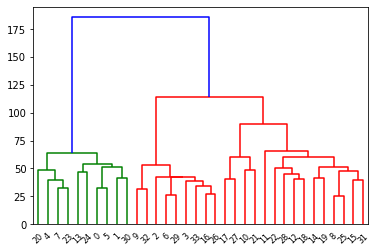

In [14]:
subtype_means = cluster_df.groupby(align_subtypes).mean()

subtype_linkage = hc.linkage(subtype_means.fillna(subtype_means.mean()), method='ward')
leaf_order = hc.dendrogram(subtype_linkage)["leaves"]

subtype_order = np.array(subtype_means.index)[leaf_order]
subtype_order = dict(zip(subtype_order,range(len(subtype_order))))

In [15]:
merged_all["type_order_index"] = merged_all["type_refined"].apply(lambda x: subtype_order[x])
merged_all = merged_all.sort_values(by="type_order_index")

def within_subtype_order(subtype_annotations):
    continuous = subtype_annotations[continuous_annotations]
    
    cell_line_linkage = hc.linkage(continuous.fillna(0), method='ward')
    leaf_order = hc.dendrogram(cell_line_linkage,no_plot=True)["leaves"]
    
    return np.array(continuous.index[leaf_order])

total_order = pd.DataFrame(merged_all.groupby("type_refined").apply(within_subtype_order))
total_order["type_order_index"] = total_order.index.map(lambda x: subtype_order[x])
total_order = total_order.sort_values(by="type_order_index")
total_order = np.concatenate(total_order[0])

merged_all = merged_all.loc[total_order]

# Prepare final plot

## Subtypes

In [16]:
unique_types = pd.DataFrame(merged_all["type_refined"].drop_duplicates(keep="first"))
unique_types.index = np.arange(len(unique_types))

type_counts = dict(Counter(merged_all["type_refined"]))

unique_types["count"] = unique_types["type_refined"].apply(lambda x: type_counts[x])

total_lines = unique_types["count"].sum()

unique_types["cumulative_count"] = unique_types["count"].cumsum()
unique_types["cumulative_offset"] = [0]+list(unique_types["cumulative_count"][:-1])

unique_types["spaced_position"] = unique_types.index/len(unique_types)*total_lines+total_lines/len(unique_types)*0.5

subtype_palette = sns.color_palette("tab20c", len(unique_types["type_refined"].unique()))
subtype_color_map = dict(zip(unique_types["type_refined"].unique(), subtype_palette))
subtype_colors = unique_types["type_refined"].map(subtype_color_map)

unique_types["subtype_color"] = subtype_colors

def plot_subtype(row,ax):
    y = [row["cumulative_offset"],
         row["cumulative_offset"],
         row["spaced_position"],
         row["cumulative_count"],
         row["cumulative_count"]
        ]
    
    x = [0,-1,-2,-1,0]
    
    ax.fill(x,y,c=row["subtype_color"])
    
    ax.plot([-2.75],[row["spaced_position"]],marker="o",c=row["subtype_color"],markersize=8)
    
    ax.text(-4,row["spaced_position"],row["type_refined"],ha="right",va="center")
    
    ax.set_xlim(-14,0)
    
    ax.set_title("Cancer type")

def plot_all_subtypes(ax):
    
    unique_types.apply(plot_subtype,ax=ax,axis=1)
    ax.set_ylim(0,total_lines)

    ax.axis('off')

## Mutations

In [17]:
def plot_mutations(ax):
    muts_info = merged_all[list(muts.columns)[::-1]+list(tertp_mut.columns)].astype(float)

    muts_info = muts_info.rename({"TERT_promoter_mutation":"TERT promoter"},axis=1)

    muts_info = muts_info.fillna(0.5)

    muts_cmap = sns.color_palette(["#ffffff","#eaeaea","#364f6b"])

    sns.heatmap(muts_info,
                cmap=muts_cmap,
                cbar=False,
                yticklabels=False,
                ax=ax)
    
    ax.set_title("Mutations")

## Fusions

In [18]:
def plot_fusions(ax):
    fusions_info = merged_all[select_fusions.columns].astype(float)

    fusions_cmap = sns.color_palette(["#ffffff","#364f6b"])

    sns.heatmap(fusions_info,
                cmap=fusions_cmap,
                cbar=False,
                yticklabels=False,
                ax=ax
               )
    
    ax.set_title("Fusions")

## Continuous

In [19]:
def plot_clustered(continuous_annotations,ax,title):

    annotation_linkage = hc.linkage(continuous_annotations.fillna(continuous_annotations.mean()).T, 
                                    method='ward')
    leaf_order = hc.dendrogram(annotation_linkage,no_plot=True)["leaves"]
    
    annotation_order = np.array(continuous_annotations.columns)[leaf_order]
    
    sns.heatmap(continuous_annotations.loc[:,annotation_order],
                ax=ax,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                cmap="bwr",
                rasterized=True
               )
    
    ax.set_title(title)


## MSI, ploidy, and ancestry

In [20]:
def plot_other(ax):

    other_annotations = merged_all[[
        "CCLE.MSI.call", "ploidy", "inferred_ancestry"]]

    other_annotations.columns = ["MSI", "Ploidy", "Ancestry"]

    # other_annotations["Ploidy"] = np.log2(other_annotations["Ploidy"])

    ancestry_map = {"African_ancestry": 0,
                    "Asian_ancestry": 1, "European_ancestry": 2}
    other_annotations["Ancestry"] = other_annotations["Ancestry"].apply(
        lambda x: ancestry_map[x])

    other_annotations = other_annotations.astype(float)

    top = cm.get_cmap('Oranges_r', 128)
    bottom = cm.get_cmap('Blues', 128)

    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))

    premask = np.tile(np.arange(other_annotations.shape[1]), other_annotations.shape[0]).reshape(
        other_annotations.shape)

    col = np.ma.array(other_annotations, mask=premask != 0)
    ax.imshow(col, aspect="auto",cmap=ListedColormap(["white","#364f6b"]))

    col = np.ma.array(other_annotations, mask=premask != 1)
    ax.imshow(col, aspect="auto",cmap="bwr",vmin=0,vmax=4)

    col = np.ma.array(other_annotations, mask=premask != 2)
    ax.imshow(col, aspect="auto",cmap=ListedColormap(["#ff7e67","#a2d5f2","#3f72af"]))

    ax.xaxis.tick_top()
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["MSI","Ploidy","Ancestry"],rotation=90)

    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

# Make final plot

In [21]:
def subtype_dendrogram(ax):

    hc.dendrogram(subtype_linkage,orientation="left",
                  ax=ax,
                  color_threshold=0,
                  link_color_func=lambda k: "black"
                 )
    
    ax.axis("off")

In [ ]:
plt.figure(figsize=(20, 12))

spine_color = "grey"

axes_widths = [2, # dendrogram
               7, # subtypes
               4, # mutations
               2, # fusions
               4, # copy number
               4, # methylation
               4, # mRNA expression
               4, # splicing
               4, # miRNA
               3, # chromatin profiling
               4, # RPPA
               2, # MSI+ploidy+ancestry
              ]
total_width = sum(axes_widths)

cumulative_widths = [sum(axes_widths[:x]) for x in range(len(axes_widths))]

axes = [plt.subplot2grid((1,total_width), (0,cumulative_widths[x]),
                         colspan=axes_widths[x]) for x in range(len(axes_widths))]

subtype_dendrogram(axes[0])
plot_all_subtypes(axes[1])

plot_mutations(axes[2])
plot_fusions(axes[3])

plot_clustered(merged_all[select_copynumber.columns],axes[4],"Copy\nnumber")
plot_clustered(merged_all[select_meth.columns],axes[5],"DNA\nmethylation")
plot_clustered(merged_all[select_genex.columns],axes[6],"mRNA\nexpression")
plot_clustered(merged_all[select_exonusage.columns],axes[7],"Alternative\nsplicing")
plot_clustered(merged_all[select_mirna.columns],axes[8],"miRNA\nexpression")
plot_clustered(merged_all[select_chromatin.columns],axes[9],"Chromatin\nprofiling")
plot_clustered(merged_all[select_rppa.columns],axes[10],"Protein\n(RPPA)")

plot_other(axes[11])

plt.savefig("../plots/figure1.pdf",dpi=512,bbox_inches="tight")